# "Global" Homework 1

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import cv2
%matplotlib inline

## Preparations

Let's first look at the characters.

In [2]:
in_file = 'train.txt'
paths = np.array([x.strip() for x in open(in_file, 'r').readlines()])
images = {path: cv2.imread(path) for path in paths}

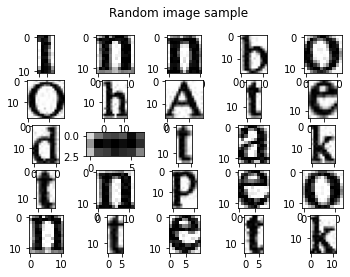

In [3]:
fig, axes = plt.subplots(5, 5)
fig.suptitle('Random image sample')
for ix, iy in np.ndindex(axes.shape):
    ax = axes[ix, iy]
    path = np.random.choice(paths)
    ax.imshow(images[path])

The first obvious problem that I see is that the images are of different sizes, which means that we can't stuff it into any standard algorithm. We may, however, expect there to be patterns in the distribution of image sizes. Let's investigate it.

(2.0, 27.0)

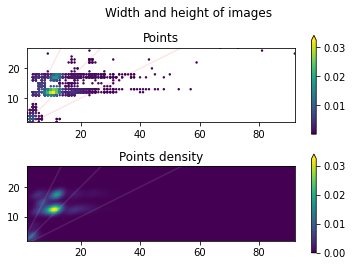

In [4]:
from scipy.stats import gaussian_kde

fig, (ax_pts, ax_pts_dens) = plt.subplots(2, 1)
fig.suptitle('Width and height of images')

w = np.array([im.shape[1] for im in images.values()])
w_min = w.min()
w_max = w.max()
w_ran = np.linspace(w_min, w_max, 1000)

h = np.array([im.shape[0] for im in images.values()])
h_min = h.min()
h_max = h.max()
h_ran = np.linspace(h_min, h_max, 1000)

X, Y = np.mgrid[w_min:w_max:0.5, h_min:h_max:0.5]
pos = np.vstack([X.ravel(), Y.ravel()])
val = np.vstack([w, h])
kde = gaussian_kde(val)
Z = np.reshape(kde(pos).T, X.shape)

ax_pts.title.set_text('Points')
ax_pts.set_aspect(1)
pts = ax_pts.scatter(w, h, c=kde(val).T, s=2)
fig.colorbar(pts, ax=ax_pts, extend='max')
for ar in [0.5, 1, 2]:
    ax_pts.plot(w_ran, ar*w_ran, c='r', alpha=0.1)
ax_pts.set_xlim([w_min, w_max])
ax_pts.set_ylim([h_min, h_max])

ax_pts_dens.title.set_text('Points density')
heat = ax_pts_dens.imshow(np.rot90(Z),
                      extent=[w_min, w_max, h_min, h_max])
fig.colorbar(heat, ax=ax_pts_dens, extend='max')
for ar in [0.5, 1, 2]:
    ax_pts_dens.plot(w_ran, ar*w_ran, c='w', alpha=0.1)
ax_pts_dens.set_aspect(1)
ax_pts_dens.set_xlim([w_min, w_max])
ax_pts_dens.set_ylim([h_min, h_max])

<AxesSubplot:title={'center':'Height'}, ylabel='Count'>

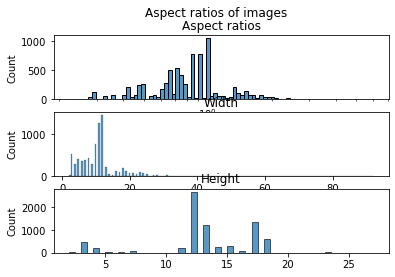

In [5]:
fig, ax = plt.subplots(3, 1)
fig.suptitle('Aspect ratios of images')

ratio = w/h
ax[0].title.set_text('Aspect ratios')
ax[0].set_xscale('log')
sns.histplot(ratio, ax=ax[0])

ax[1].title.set_text('Width')
sns.histplot(w, ax=ax[1])

ax[2].title.set_text('Height')
sns.histplot(h, ax=ax[2])

By a completely heurestic and unscientific process I have arrived at the following criteria regarding the three main classes of characters: punctuation marks, sequences of characters and standalone characters, such as letters and digits.

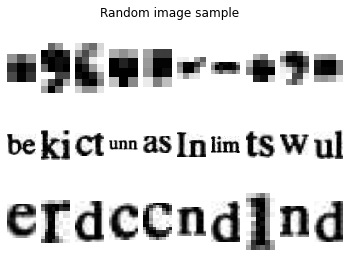

In [6]:
punct_marks = h < 10
sequences = w > 15
chars = (h >= 10) & (w <= 13)

fig, ax = plt.subplots(3, 10)
fig.suptitle('Random image sample')
for i, a in enumerate([punct_marks, sequences, chars]):
    sel = np.random.choice(paths[a], size=10)
    for j in range(10):
        ax[i,j].axis('off')
        ax[i,j].imshow(images[sel[j]], cmap='gray')

## Punctuation marks
It's (I think) not necessary to do anything complicated here. Whatever's of sufficient length is (en- or em-)dash, and otherwise if it's tall enough it's a comma. In all other cases it's a full stop.

<AxesSubplot:ylabel='Count'>

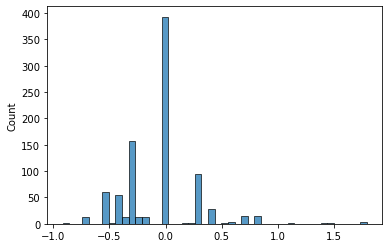

In [7]:
fig, ax = plt.subplots()
sns.histplot(np.log((w/h))[h < 10], ax=ax)

In [8]:
punct_clusters = [
    paths[(h < 10) & (w/h > 2)],
    paths[(h < 10) & (w/h < 2) & (h/w > 1.5)],
    paths[(h < 10) & (w/h < 2) & (h/w <= 1.5)],
]

## Image scaling etc.
We shall transform the images to a common format (I chose 16x16 because it's still legible and should improve the performance), and other than that we will apply a threshold so as to make the shapes clearer.

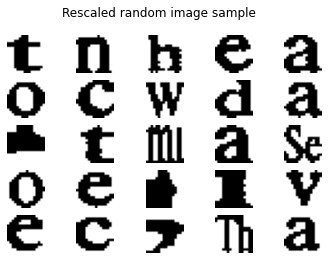

In [9]:
def rescale(image):
    x = image
    x = cv2.resize(x, (16, 16), interpolation=cv2.INTER_CUBIC)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    _, x = cv2.threshold(x, 0, 255, cv2.THRESH_OTSU)
    return x

rescaled = {path: rescale(images[path])
            for path in paths}

fig, axes = plt.subplots(5, 5)
fig.suptitle('Rescaled random image sample')
for ix, iy in np.ndindex(axes.shape):
    ax = axes[ix, iy]
    path = np.random.choice(paths)
    ax.axis('off')
    ax.imshow(rescaled[path], cmap='gray')

We will transform these images into a form suitable for `sklearn` (i.e. 1d); we will also add height and width information to the mix.

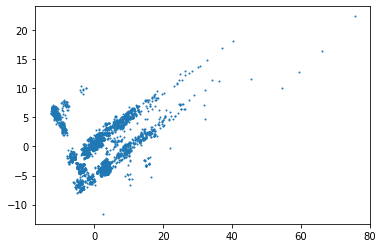

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = np.array([np.asarray(rescaled[path])
              for path in paths])
X = X / 255

X_sk = X.reshape((-1, 16*16))
X_sk = np.hstack([X_sk, w.reshape((-1, 1)), h.reshape((-1, 1))])
tX_sk = PCA(n_components=64).fit_transform(X_sk)

fig, ax = plt.subplots()
ax.scatter(tX_sk[:,0], tX_sk[:,1], s=1)

## Characters
We may conjecture the number of clusters here to be tightly upper-bound. I myself chose 32 because (1) it's close to the number of letters in English alphabet, (2) it's slightly greater than that, so it should provide some room for weird point-cloud shapes. It also means that some clusters will essentially have the same characters, but it's in my estimation acceptable.

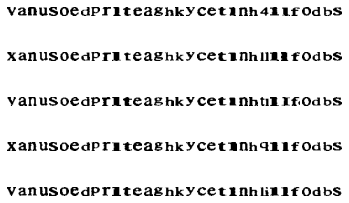

In [11]:
from sklearn.cluster import AgglomerativeClustering

Xc_sk = X_sk[chars]
tXc_sk = PCA(n_components=64).fit_transform(Xc_sk)

char_clust = AgglomerativeClustering(n_clusters=32).fit(tXc_sk)
char_vals = np.unique(char_clust.labels_)

fig, ax = plt.subplots(5, char_vals.shape[0])
for j in char_vals:
    ix = np.random.choice(np.argwhere(char_clust.labels_ == j).ravel(), 5)
    for i, k in enumerate(ix):
        ax[i,j].axis('off')
        ax[i,j].imshow(X[chars][k], cmap='gray')

## Sequences
Usually there'd be nothing special to do here, but in the midst of this class lie `w` and `m`, which we may want to extract. We do it via `OPTICS` clustering method, because it takes minimum number of samples necessary, perfect for our application.

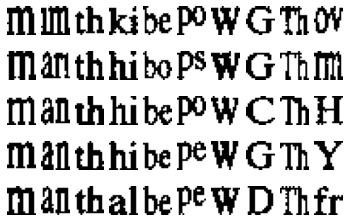

In [12]:
from sklearn.cluster import OPTICS

Xs_sk = X_sk[sequences]
tXs_sk = PCA(n_components=64).fit_transform(Xs_sk)

seq_clust = OPTICS(min_samples=25).fit(tXs_sk)
seq_vals = np.unique(seq_clust.labels_)

fig, ax = plt.subplots(5, seq_vals.shape[0])
for j in seq_vals:
    ix = np.random.choice(np.argwhere(seq_clust.labels_ == j).ravel(), 5)
    for i, k in enumerate(ix):
        ax[i,j].axis('off')
        ax[i,j].imshow(X[sequences][k], cmap='gray')

## Output

In [13]:
clusters = [
    *punct_clusters,
    *(paths[chars][char_clust.labels_ == v] for v in char_vals),
    *(paths[sequences][seq_clust.labels_ == v] for v in seq_vals if v >= 0),
    *([seq] for seq in paths[sequences][seq_clust.labels_ == -1])
]

In [14]:
from jinja2 import Template
html = Template(open('output.j2', 'r').read())

text = html.render(clusters=clusters)
open('output.html', 'w').write(text)

437836